In [30]:
# Import libraries
import os
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score,
    roc_auc_score, roc_curve, confusion_matrix,
    classification_report, ConfusionMatrixDisplay
)
from scipy.sparse import hstack
from wordcloud import WordCloud

In [ ]:
# Read the TSV file from the specified file path
amazon_df = pd.read_csv("data/amazon_alexa.tsv", sep='\t')

# Display the first 5 rows of the dataset to preview the structure and content of the dataset
display(amazon_df.head())

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [32]:
# Extract the number of rows and columns from the dataset
num_row, num_column = amazon_df.shape

# Displays the total number of rows
print("Number of rows:", num_row)

# Displays the total number of columns
print("Number of columns:", num_column) 

Number of rows: 3150
Number of columns: 5


In [33]:
# Display descriptive statistics for all columns, including numeric and non-numeric data
amazon_df.describe(include='all')

,rating,date,variation,verified_reviews,feedback
count,3150.000000,3150,3150,3149,3150.000000
unique,NaN,77,16,2300,NaN
top,NaN,30-Jul-18,Black Dot,,NaN
freq,NaN,1603,516,79,NaN
mean,4.463175,NaN,NaN,NaN,0.918413
std,1.068506,NaN,NaN,NaN,0.273778
min,1.000000,NaN,NaN,NaN,0.000000
25%,4.000000,NaN,NaN,NaN,1.000000
50%,5.000000,NaN,NaN,NaN,1.000000
75%,5.000000,NaN,NaN,NaN,1.000000


In [34]:
# Count the number of rows with empty 'verified_reviews'
empty_reviews_count = len(amazon_df[amazon_df['verified_reviews'] == ' '])
print(f"Number of rows with empty 'verified_reviews': {empty_reviews_count}")

Number of rows with empty 'verified_reviews': 79


In [35]:
# Check the count of missing values in each column
print("Missing Values Count:")
print(amazon_df.isnull().sum())

Missing Values Count:
rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64


In [36]:
# Replace all occurrences of ' ' in 'verified_reviews' with NaN, indicating missing values
amazon_df['verified_reviews'] = amazon_df['verified_reviews'].replace(' ', np.nan)

# Check the count of missing values in each column after replacement
print("Missing Values Count:")
print(amazon_df.isnull().sum())

Missing Values Count:
rating               0
date                 0
variation            0
verified_reviews    80
feedback             0
dtype: int64


In [37]:
# Fill missing values in 'verified_reviews' with an empty string
amazon_df['verified_reviews'] = amazon_df['verified_reviews'].fillna('')

# Display the count of missing values in each column after filling 'verified_reviews'
print("Missing Values Count:")
print(amazon_df.isnull().sum())

Missing Values Count:
rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64


In [38]:
# Display the summary of the dataset
amazon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [39]:
# Parse the 'date' column with the specified format for proper date-based operations
amazon_df['date'] = pd.to_datetime(amazon_df['date'], format='%d-%b-%y', errors='coerce')

# Verify the first few parsed values in the 'date' column
print("Parsed 'date' column (after converting to datetime):")
print(amazon_df['date'])

Parsed 'date' column (after converting to datetime):
0      2018-07-31
1      2018-07-31
2      2018-07-31
3      2018-07-31
4      2018-07-31
          ...    
3145   2018-07-30
3146   2018-07-30
3147   2018-07-30
3148   2018-07-30
3149   2018-07-29
Name: date, Length: 3150, dtype: datetime64[ns]


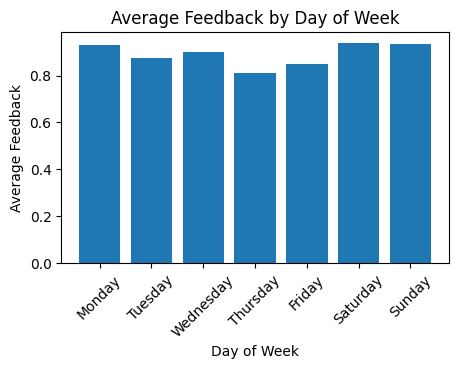

In [40]:
# List of mapping for day numbers to weekday names
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
               4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

# Extract the day of the week from the 'date' column to analyze trends based on weekdays
amazon_df['day_of_week'] = amazon_df['date'].dt.dayofweek

# Calculate the average feedback for each day of the week to identify day-specific patterns
feedback_by_day = amazon_df.groupby('day_of_week')['feedback'].mean()

# Plot bar plot to visualize the average feedback by day of the week
plt.figure(figsize=(5, 3))
plt.bar(feedback_by_day.index, feedback_by_day.values)
plt.xticks(ticks=feedback_by_day.index, 
           labels=[day_mapping[i] for i in feedback_by_day.index], # Use weekday names for labels
           rotation=45)
plt.title("Average Feedback by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Feedback")
plt.show()

Distribution of Feedback (0 = Negative, 1 = Positive):
feedback
1    2893
0     257
Name: count, dtype: int64


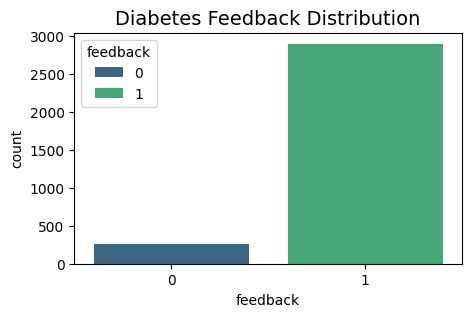

In [41]:
# Check the distribution of the 'feedback' variable to understand the dataset's balance
print("Distribution of Feedback (0 = Negative, 1 = Positive):")
print(amazon_df['feedback'].value_counts())

# Plot bar plot to visualize the distribution of feedback categories
plt.figure(figsize=(5, 3))
sns.countplot(x='feedback', data=amazon_df, hue='feedback', palette='viridis')
plt.title('Diabetes Feedback Distribution', fontsize=14)
plt.show()

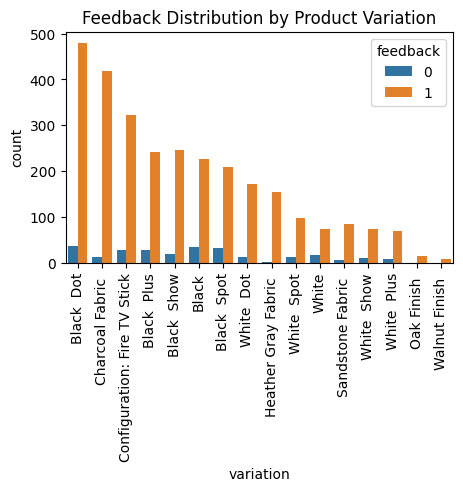

In [42]:
# Plot feedback distribution by product variation
plt.figure(figsize=(5, 3))
sns.countplot(x='variation', hue='feedback', data=amazon_df, 
              order=amazon_df['variation'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Feedback Distribution by Product Variation')
plt.show()

Ratings Distribution (All Feedback):
 rating
1     161
2      96
3     152
4     455
5    2286
Name: count, dtype: int64


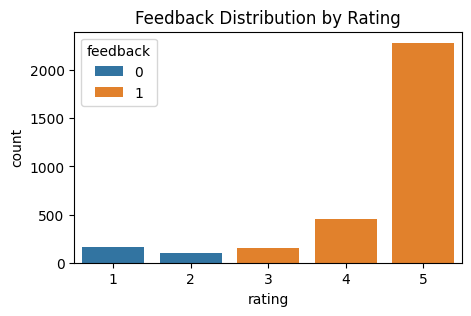

In [43]:
# Calculate the distribution of ratings for all feedback
ratings_distribution = amazon_df['rating'].value_counts().sort_index()
print("Ratings Distribution (All Feedback):\n", ratings_distribution)

# Plot feedback distribution by rating
plt.figure(figsize=(5, 3))
sns.countplot(x='rating', hue='feedback', data=amazon_df)
plt.title('Feedback Distribution by Rating')
plt.show()

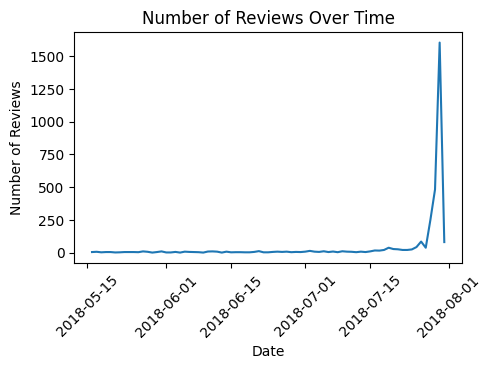

In [44]:
# Group reviews by date and count their occurrences to analyze temporal trends
df_date = amazon_df.groupby(amazon_df['date']).size()

# Plot the trend of reviews over time
plt.figure(figsize=(5, 3))
plt.plot(df_date)
plt.title('Number of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

In [45]:
# Identify the date(s) with the maximum number of reviews
peak_date = df_date[df_date == df_date.max()].index
print(f"Date with the highest reviews: {peak_date[0]}")

# Filter the dataset for the peak dates
spike_data = amazon_df[amazon_df['date'].isin(peak_date)]
display(spike_data)

Date with the highest reviews: 2018-07-30 00:00:00


,rating,date,variation,verified_reviews,feedback,day_of_week
8,5,2018-07-30,Heather Gray Fabric,looks great,1,0
9,5,2018-07-30,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1,0
10,5,2018-07-30,Charcoal Fabric,"I sent it to my 85 year old Dad, and he talks ...",1,0
11,5,2018-07-30,Charcoal Fabric,I love it! Learning knew things with it eveyda...,1,0
12,5,2018-07-30,Oak Finish,I purchased this for my mother who is having k...,1,0
...,...,...,...,...,...,...
3144,5,2018-07-30,Black Dot,love it,1,0
3145,5,2018-07-30,Black Dot,"Perfect for kids, adults and everyone in betwe...",1,0
3146,5,2018-07-30,Black Dot,"Listening to music, searching locations, check...",1,0
3147,5,2018-07-30,Black Dot,"I do love these things, i have them running my...",1,0


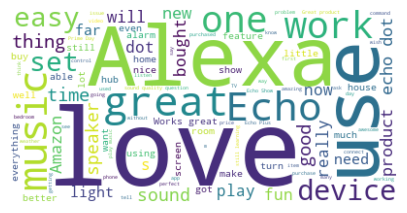

In [46]:
# Create a word cloud with a white background and 100 word limit
wc = WordCloud(background_color='white', max_words=100)

# Combine all reviews into a single string for word cloud generation
reviews = ' '.join(amazon_df['verified_reviews'])

# Generate the word cloud from the combined reviews
wordcloud = wc.generate(reviews)

# Visualize the generated word cloud
plt.figure(figsize=(5, 3))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

In [47]:
# Select numeric columns (int64, float64) from the dataset
amazon_df_numeric = amazon_df.select_dtypes(include=['int64', 'float64'])

In [48]:
# Find correlation with 'feedback'
correlation = amazon_df_numeric.corr()['feedback'].sort_values(ascending=False)
print("Correlated Features with 'feedback':")
print(correlation)

Correlated Features with 'feedback':
feedback    1.000000
rating      0.861968
Name: feedback, dtype: float64


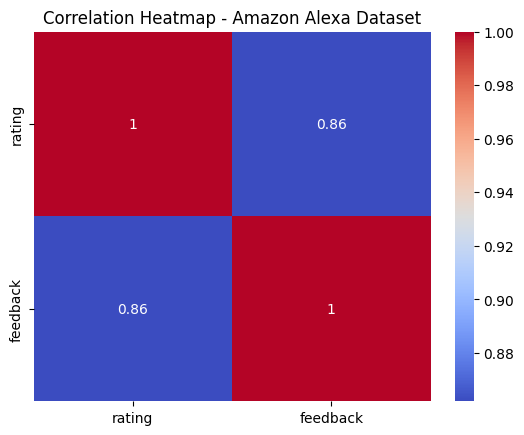

In [49]:
# Heatmap for correlations in dataset
sns.heatmap(amazon_df_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap - Amazon Alexa Dataset')
plt.show()

In [50]:
# English stopwords to remove common but uninformative words
stop_words = set(stopwords.words('english'))  

# WordNet Lemmatizer to reduce words to their base form
lemmatizer = WordNetLemmatizer()

# Function to map simpler version of pos tag for lemmatization
def get_wordnet_pos(tag):
    if tag.startswith('J'):  # Adjective
        return wordnet.ADJ
    elif tag.startswith('V'):  # Verb
        return wordnet.VERB
    elif tag.startswith('N'):  # Noun
        return wordnet.NOUN
    elif tag.startswith('R'):  # Adverb
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun when no specific tag matches

In [51]:
# Function to clean and preprocess text
def clean_text(text):
    
    # Convert text to lowercase for uniformity and to avoid case-sensitive mismatches
    text = text.lower()
    
    # Remove special characters and punctuation to keep only alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Normalize multiple text spaces into a single text space
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Lemmatize words with POS tagging and remove stopwords for meaningful text analysis
    tokens = text.split()
    tokens_pos = pos_tag(tokens)  # Get POS tags
    text = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(pos)) 
                     for word, pos in tokens_pos if word not in stop_words])
    
    return text

# Apply the text cleaning function to the 'verified_reviews' column to preprocess reviews for analysis
amazon_df['cleaned_reviews'] = amazon_df['verified_reviews'].apply(clean_text)

# Display the first 5 rows of the dataframe to verify the preprocessing
display(amazon_df.head())

,rating,date,variation,verified_reviews,feedback,day_of_week,cleaned_reviews
0,5,2018-07-31,Charcoal Fabric,Love my Echo!,1,1,love echo
1,5,2018-07-31,Charcoal Fabric,Loved it!,1,1,love
2,4,2018-07-31,Walnut Finish,"Sometimes while playing a game, you can answer...",1,1,sometimes play game answer question correctly ...
3,5,2018-07-31,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,1,lot fun thing yr old learn dinosaur control li...
4,5,2018-07-31,Charcoal Fabric,Music,1,1,music


In [52]:
# Shuffle rows before splitting data into features (X) and outcome (Y)
amazon_df = shuffle(amazon_df, random_state=42)

In [53]:
# One-hot encode the 'variation' column to represent categorical data numerically for model compatibility
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore') 
encoded_variation = encoder.fit_transform(amazon_df[['variation']])

# Convert the sparse matrix to a dense DataFrame to visualize the one-hot encoded output
encoded_variation_df = pd.DataFrame(encoded_variation.toarray(), 
                                    columns=encoder.get_feature_names_out(['variation']))

# Display the first 5 records of the dataframe after one-hot encoding
display(encoded_variation_df.head())

,variation_Black,variation_Black Dot,variation_Black Plus,variation_Black Show,variation_Black Spot,variation_Charcoal Fabric,variation_Configuration: Fire TV Stick,variation_Heather Gray Fabric,variation_Oak Finish,variation_Sandstone Fabric,variation_Walnut Finish,variation_White,variation_White Dot,variation_White Plus,variation_White Show,variation_White Spot
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [54]:
# Convert text data into numerical features for model input using CountVectorizer
vectorizer = CountVectorizer(max_features=2000, ngram_range=(1, 2))
vectorized_reviews = vectorizer.fit_transform(amazon_df['cleaned_reviews'])

# Display the first 10 extracted features
print("First 10 features extracted by CountVectorizer:")
print(vectorizer.get_feature_names_out()[:10])

# Display the first 5 rows of the vectorized reviews
print("\nNumerical representation of the first 5 reviews:")
print(vectorized_reviews.toarray()[:5])

First 10 features extracted by CountVectorizer:
['ability' 'able' 'able listen' 'able play' 'able see' 'able set'
 'able tell' 'able use' 'able watch' 'absolutely']

Numerical representation of the first 5 reviews:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 0]]


In [55]:
# Combine text and variation features into a single feature matrix for model input
X = hstack([vectorized_reviews, encoded_variation])

# Target variable (feedback) for prediction
y = amazon_df['feedback']

# Split data into 80% training and 20% testing sets with stratified sampling to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, 
                                                    random_state=42)

In [56]:
# Train a Random Forest Classifier on the training data
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Use the trained Random Forest Classifier to make predictions on the test set
y_rf_pred = rf.predict(X_test)  # Predicted labels
y_rf_proba = rf.predict_proba(X_test)  # Predicted probabilities for ROC-AUC calculation

# Evaluation metrics to assess model performance
rf_accuracy = accuracy_score(y_test, y_rf_pred) 
rf_precision = precision_score(y_test, y_rf_pred)  
rf_recall = recall_score(y_test, y_rf_pred)
rf_roc_auc = roc_auc_score(y_test, y_rf_proba[:, 1])
rf_classification_report = classification_report(y_test, y_rf_pred, target_names=['Negative', 'Positive'])
rf_confusion_matrix = confusion_matrix(y_test, y_rf_pred)

# Display the evaluation metrics for the Random Forest Classifier
print("Random Forest Model Evaluation:")
print(f"Accuracy: {rf_accuracy * 100:.2f}%")
print(f"Precision: {rf_precision:.2f}")
print(f"Recall: {rf_recall:.2f}")
print(f"ROC-AUC Score: {rf_roc_auc:.2f}")
print("\nClassification Report:")
print(rf_classification_report)

Random Forest Model Evaluation:
Accuracy: 93.97%
Precision: 0.95
Recall: 0.98
ROC-AUC Score: 0.90

Classification Report:
              precision    recall  f1-score   support

    Negative       0.71      0.43      0.54        51
    Positive       0.95      0.98      0.97       579

    accuracy                           0.94       630
   macro avg       0.83      0.71      0.75       630
weighted avg       0.93      0.94      0.93       630



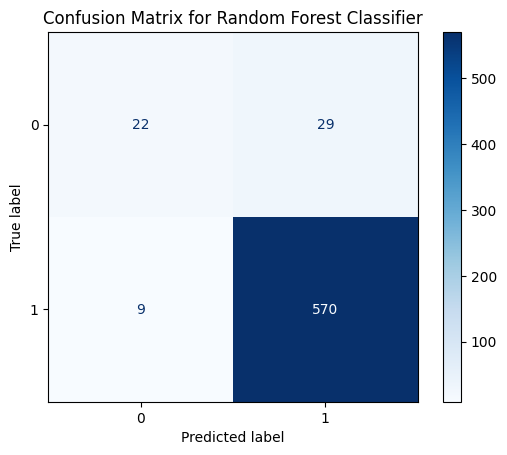

In [57]:
# Display the confusion matrix for Random Forest Classifier
ConfusionMatrixDisplay(confusion_matrix=rf_confusion_matrix).plot(cmap='Blues')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

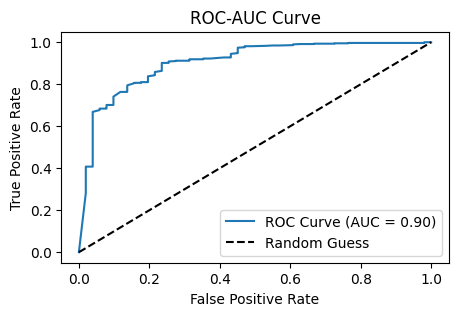

In [58]:
# False Positive Rate, True Positive Rate, and thresholds of the ROC-AUC curve for the model
fpr, tpr, thresholds = roc_curve(y_test, y_rf_proba[:, 1])

# Display the ROC-AUC Curve for Random Forest Classifier
plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {rf_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess") # Add a diagonal line to represent random guessing
plt.title("ROC-AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()